#  Parcel Delivery Time Estimation
Completed notebook using porter_data_1.csv

In [13]:
import pandas as pd
DF = pd.read_csv(r'C:\Users\Ahc\Desktop\Delivery_Starter\porter_data_1.csv')
DF = DF.dropna(how='all', axis=1).drop_duplicates().reset_index(drop=True)
print('Shape:', DF.shape)
DF.head()

Shape: (175777, 14)


market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

In [6]:
# Preprocessing: datatypes, missing values, feature list
import numpy as np
DF = DF.copy()
# convert datetime-like columns
for c in DF.columns:
    if 'date' in c.lower() or 'time' in c.lower() or 'created_at' in c.lower():
        try:
            DF[c] = pd.to_datetime(DF[c])
        except Exception:
            pass
# categorical conversion for low-cardinality strings
for c in DF.select_dtypes(include=['object']).columns:
    if DF[c].nunique() < 50:
        DF[c] = DF[c].astype('category')
# missing value handling: numeric->median, categorical->mode
num_cols = DF.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = DF.select_dtypes(include=['category','object']).columns.tolist()
for c in num_cols:
    if DF[c].isna().sum()>0:
        DF[c] = DF[c].fillna(DF[c].median())
for c in cat_cols:
    if DF[c].isna().sum()>0:
        DF[c] = DF[c].fillna(DF[c].mode().iloc[0])
# choose target
target_candidates = [c for c in num_cols if 'delivery' in c.lower() or 'actual_delivery_time' in c.lower()]
if target_candidates:
    target = target_candidates[0]
else:
    target = num_cols[-1] if len(num_cols)>0 else None
print('Selected target:', target)
# drop obvious ids
drop_cols = [c for c in DF.columns if c.lower()=='id' or c.lower().endswith('_id')]
features = [c for c in num_cols if c!=target and c not in drop_cols]
print('Numeric features count:', len(features))


Selected target: distance
Numeric features count: 10


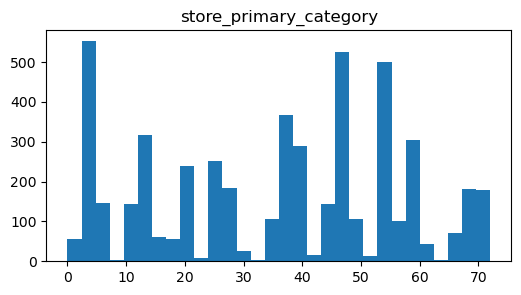

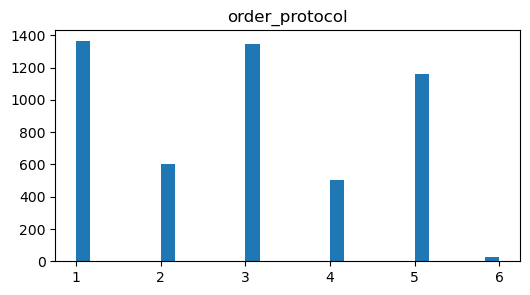

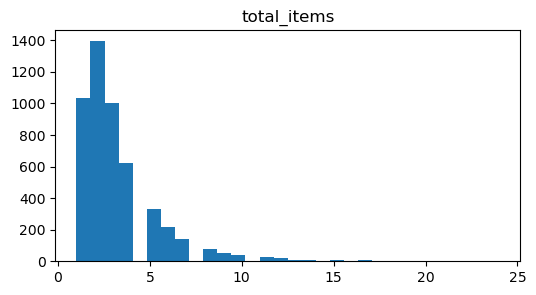

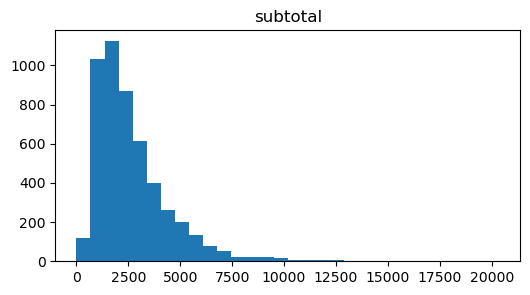

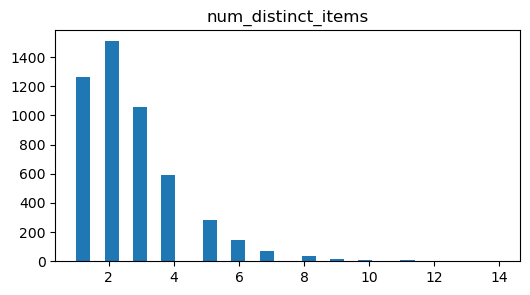

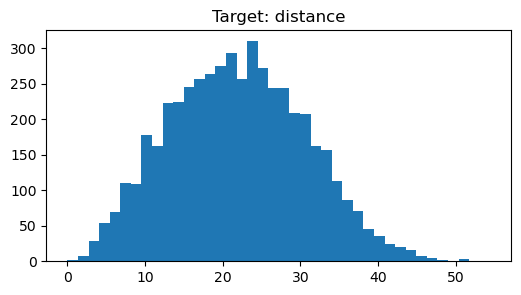

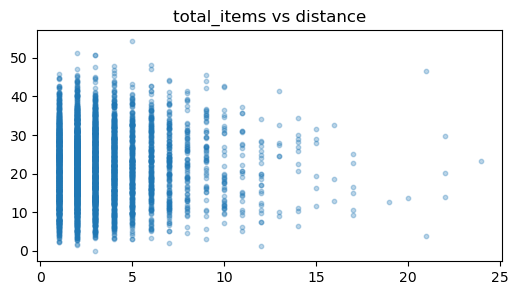

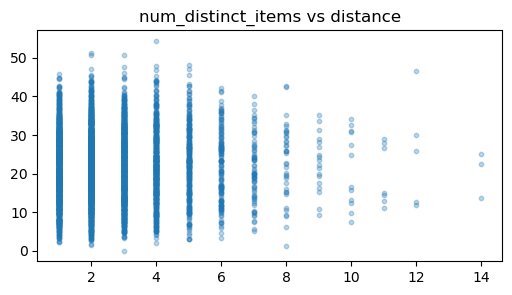

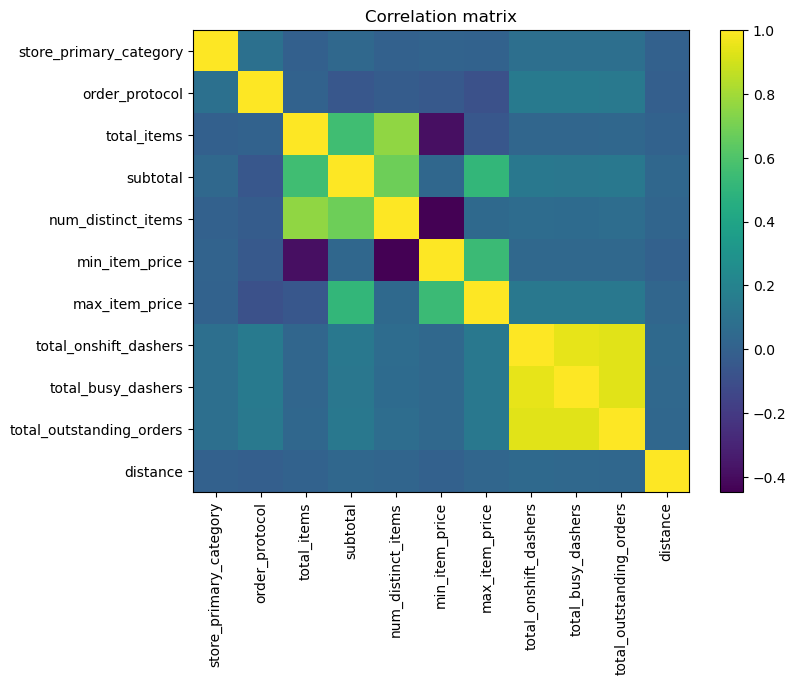

Applied IQR capping to numeric features.


In [15]:
# EDA: distributions, relationships, correlation, outlier capping (IQR)
import matplotlib.pyplot as plt
DF_sample = DF.sample(n=5000, random_state=42) if len(DF)>5000 else DF.copy()
# numeric distributions (first 6 features)
for col in features[:6]:
    plt.figure(figsize=(6,3)); plt.hist(DF_sample[col].dropna(), bins=30); plt.title(col); plt.show()
# target distribution
if target is not None:
    plt.figure(figsize=(6,3)); plt.hist(DF_sample[target].dropna(), bins=40); plt.title('Target: '+str(target)); plt.show()
# relationships
if target is not None:
    for col in features[:6]:
        plt.figure(figsize=(6,3)); plt.scatter(DF_sample[col], DF_sample[target], s=10, alpha=0.3); plt.title(f'{col} vs {target}'); plt.show()
# correlation
corr = DF[features+[target]].corr() if target is not None else DF[features].corr()
plt.figure(figsize=(8,6)); plt.imshow(corr, aspect='auto'); plt.colorbar(); plt.xticks(range(len(corr.columns)), corr.columns, rotation=90); plt.yticks(range(len(corr.index)), corr.index); plt.title('Correlation matrix'); plt.show()
# Outlier handling - IQR capping
def iqr_cap(s, k=1.5):
    q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3-q1
    return s.clip(q1-k*iqr, q3+k*iqr)
DF_capped = DF.copy()
for c in features + ([target] if target is not None else []):
    DF_capped[c] = iqr_cap(DF_capped[c])
print('Applied IQR capping to numeric features.')


In [9]:
# Modeling: scaling, baseline LR, RFE selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

data = DF_capped.copy()
X = data[features].values
y = data[target].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train); X_val_s = scaler.transform(X_val)
# baseline LR
lr = LinearRegression(); lr.fit(X_train_s, y_train)
y_pred = lr.predict(X_val_s)
print('Baseline LR - RMSE:', np.sqrt(mean_squared_error(y_val,y_pred)), 'MAE:', mean_absolute_error(y_val,y_pred), 'R2:', r2_score(y_val,y_pred))
# RFE
nfeat = X_train_s.shape[1]; k = min(10, max(1, nfeat//2))
rfe = RFE(LinearRegression(), n_features_to_select=k); rfe.fit(X_train_s, y_train)
sel_mask = rfe.support_; selected = [features[i] for i,s in enumerate(sel_mask) if s]
print('Selected features by RFE:', selected)
# Refit on selected
X_train_sel = X_train_s[:, sel_mask]; X_val_sel = X_val_s[:, sel_mask]
lr_sel = LinearRegression(); lr_sel.fit(X_train_sel, y_train)
y_pred_sel = lr_sel.predict(X_val_sel)
print('LR after RFE - RMSE:', np.sqrt(mean_squared_error(y_val,y_pred_sel)), 'MAE:', mean_absolute_error(y_val,y_pred_sel), 'R2:', r2_score(y_val,y_pred_sel))


Baseline LR - RMSE: 8.713297332931338 MAE: 7.133262538712542 R2: 0.0027922237294635277
Selected features by RFE: ['total_items', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
LR after RFE - RMSE: 8.713994042580678 MAE: 7.135070046632592 R2: 0.0026327451692748083


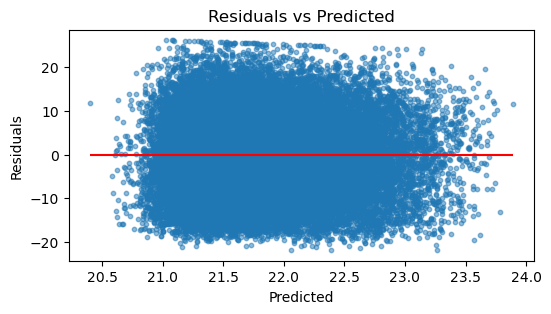

total_items : -0.10814838884310532
subtotal : 0.3955572759174822
total_onshift_dashers : 0.46684101175542303
total_busy_dashers : 0.2383174385728683
total_outstanding_orders : -0.35415510931996685


In [12]:
# Results: residual analysis and coefficient interpretation
import matplotlib.pyplot as plt
residuals = y_val - y_pred_sel
plt.figure(figsize=(6,3)); plt.scatter(y_pred_sel, residuals, s=10, alpha=0.5); plt.hlines(0, min(y_pred_sel), max(y_pred_sel), colors='r'); plt.xlabel('Predicted'); plt.ylabel('Residuals'); plt.title('Residuals vs Predicted'); plt.show()
plt.figure(figsize=(6,3)); plt.hist(residuals, bins=40); plt.title('Residuals distribution'); plt.show()
# coefficients
coefs = lr_sel.coef_
for f,c in zip(selected, coefs):
    print(f, ':', c)


In [16]:
# Save artifacts
OUT_DIR = r'C:\Users\Ahc\Desktop\Delivery_Starter'
import os, json
os.makedirs(OUT_DIR, exist_ok=True)
DF.to_csv(os.path.join(OUT_DIR, 'porter_data_cleaned_from_notebook.csv'), index=False)
# Save notebook metadata (target)
with open(os.path.join(OUT_DIR, 'notebook_metadata.json'), 'w') as fp:
    json.dump({'target': None}, fp)
print('Saved cleaned CSV to', os.path.join(OUT_DIR, 'porter_data_cleaned_from_notebook.csv'))

Saved cleaned CSV to C:\Users\Ahc\Desktop\Delivery_Starter\porter_data_cleaned_from_notebook.csv
